# Метрики качества бинарной классификации

Павел Филонов (filonovpv@gmail.com)

## Обнаружение мошеннических транзакций

### Загрузка данных
На основе [Machine Learning for Credit Card Fraud Detection](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html)

In [2]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
if not os.path.exists("shared_functions.py"):
    !curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

In [5]:
DIR_INPUT='./simulated-data-transformed/data/' 

BEGIN_DATE = "2018-05-01"
END_DATE = "2018-05-31"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 217 ms, sys: 239 ms, total: 455 ms
Wall time: 470 ms
297115 transactions loaded, containing 2639 fraudulent transactions


In [6]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,288062,2018-05-01 00:01:21,3546,2944,18.71,2592081,30,0,0,0,...,17.0,44.430588,89.0,42.628652,0.0,0.0,12.0,0.0,36.0,0.0
1,288063,2018-05-01 00:01:48,206,3521,18.60,2592108,30,0,0,0,...,26.0,27.461538,104.0,26.104038,6.0,0.0,11.0,0.0,38.0,0.0
2,288064,2018-05-01 00:02:22,2610,4470,66.67,2592142,30,0,0,0,...,26.0,46.767692,110.0,50.019727,1.0,0.0,5.0,0.0,22.0,0.0
3,288065,2018-05-01 00:03:15,4578,1520,79.41,2592195,30,0,0,0,...,17.0,83.097647,69.0,91.713188,0.0,0.0,8.0,0.0,33.0,0.0
4,288066,2018-05-01 00:03:51,1246,7809,52.08,2592231,30,0,0,0,...,35.0,52.931714,130.0,55.928385,0.0,0.0,6.0,0.0,19.0,0.0


In [27]:
from sklearn.model_selection import train_test_split

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

X = transactions_df[input_features]
y = transactions_df[output_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_params = {
    'n_neighbors': 5,
}

knn = KNeighborsClassifier(**knn_params).fit(X_train, y_train)

knn_y_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_y_pred)
print(f"Доля верных ответов для knn: {knn_acc:.4}")

Доля верных ответов для knn: 0.9937
CPU times: user 16.6 s, sys: 503 ms, total: 17.1 s
Wall time: 18.9 s


## Классификатор "болванчик"

Этот классификатор просто предсказывает самый частый выходной класс (или случайный класс) без учета значений входных признаков.

Данный тип классификаторов можно рассматривать в качестве простых базовых оценок для метрик классификации. Любой предложенный алгоритм должен показывать качество лучше, чем "болванчик"

In [208]:
%%time
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier().fit(X_train, y_train)

dummy_y_pred = dummy.predict(X_test)
dummy_acc = accuracy_score(y_test, dummy_y_pred)
print(f"Доля верных ответов для dummy: {dummy_acc:.4}")

Доля верных ответов для dummy: 0.9916
CPU times: user 19.6 ms, sys: 46.1 ms, total: 65.7 ms
Wall time: 137 ms


### Дизбаланс классов

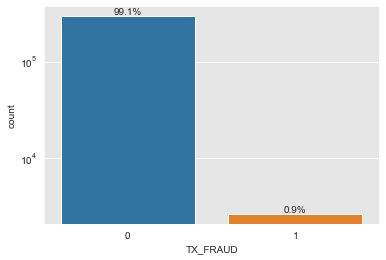

In [29]:
ax = sns.countplot(x=y)
ax.set_yscale('log')
total = len(y)
for p in ax.patches:
    px = p.get_bbox().get_points()[:,0]
    py = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*py/total), (px.mean(), py), 
            ha='center', va='bottom') # set the alignment of the text

### Матрица ошибок бинарной классификации
<img src="https://miro.medium.com/max/332/1*BTB9weIUfSsSRy5kvh_-uA.png" />

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

### Матрица ошибок для "болванчика"

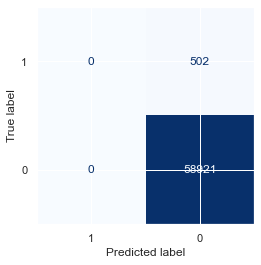

In [207]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(dummy, X_test, y_test, cmap=plt.cm.Blues, labels=[1, 0], colorbar=False);

### Матрица ошибок для kNN

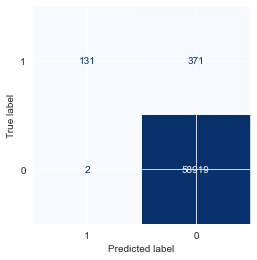

In [36]:
plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues, labels=[1, 0], colorbar=False);

### Точность и полнота


**Точность** (Precision) - Доля правильных ответов, среди всех _предсказаний_ позитивного класса
$$
P = \frac{TP}{TP + FP}
$$

**Полнота** (Recall) - доля правильных ответов среди всех _истинных_ примеров позитивного класса
$$
R = \frac{TP}{TP + FN}
$$

In [55]:
from sklearn.metrics import precision_score, recall_score

dummy_precision = precision_score(y_test, dummy_y_pred)
dummy_recall = recall_score(y_test, dummy_y_pred)

knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

print(f"Dummy precision = {dummy_precision:.5}")
print(f"Dummy recall = {dummy_recall:.5}")
print("")
print(f"kNN precision = {knn_precision:.4}")
print(f"kNN recall = {knn_recall:.4}")

Dummy precision = 0.0
Dummy recall = 0.0

kNN precision = 0.985
kNN recall = 0.261


### Сравнение классификаторов

Обучим логистическую регрессию

In [57]:
%%time
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)
logreg_y_pred = logreg.predict(X_test)

CPU times: user 5.31 s, sys: 419 ms, total: 5.73 s
Wall time: 3.48 s


In [58]:
logreg_precision = precision_score(y_test, logreg_y_pred)
logreg_recall = recall_score(y_test, logreg_y_pred)

In [59]:
print(f"LogReg precision = {logreg_precision:.5}")
print(f"LogReg recall = {logreg_recall:.5}")
print("")
print(f"kNN precision = {knn_precision:.4}")
print(f"kNN recall = {knn_recall:.4}")

LogReg precision = 0.75704
LogReg recall = 0.42829

kNN precision = 0.985
kNN recall = 0.261


## F мера

$F_1$ мера - гармоническое среднее между точностью и полнотой
$$
F_1 = \frac{2PR}{P+R}.
$$

$F_\beta$ - обобщенние $F$-меры, использующая коэффициент $\beta$ - степень важности полноты по сравнению с точностью. 
$$
F_\beta = (1+\beta^2)\frac{PR}{\beta^2 P + R} = \frac{(1+\beta^2)TP}{(1+\beta^2)TP + \beta^2 FN + FP}.
$$

In [60]:
from sklearn.metrics import f1_score

knn_f1 = f1_score(y_test, knn_y_pred)
logreg_f1 = f1_score(y_test, logreg_y_pred)

print(f"LogReg F1 = {logreg_f1:.5}")
print(f"kNN F1 = {knn_f1:.5}")

LogReg F1 = 0.54707
kNN F1 = 0.4126


## PR (Precison Recall)-кривая

Рассмотрим упрощенную задачу бинарной классификации, когда у нас есть всего 1 признак.

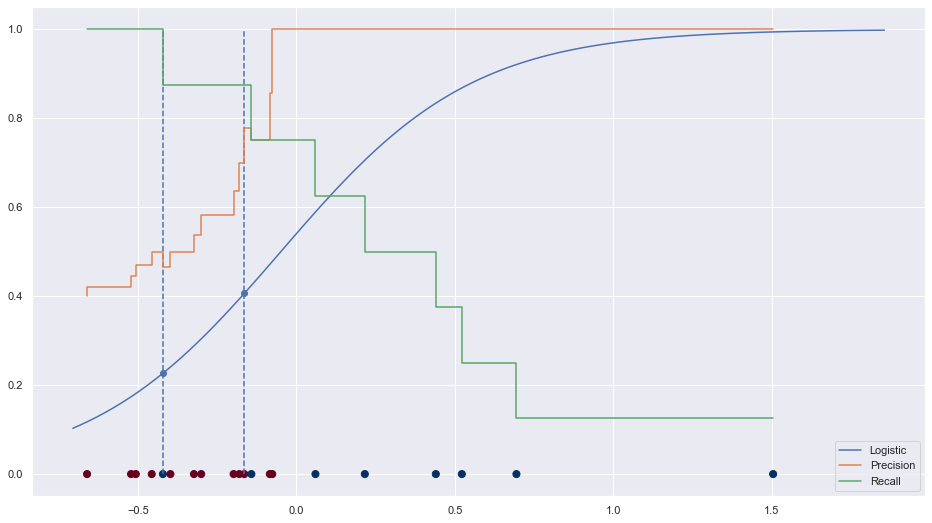

In [198]:
sns.set()

from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from scipy.special import logit

def sinlge_dim_ex():
    X, y = make_classification(
        n_samples=100, 
        n_classes=2,
        n_clusters_per_class=1,
        n_features=1,
        n_informative=1,
        n_redundant=0,
        n_repeated=0,
        class_sep=0.4,
        random_state=42,
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    logreg = LogisticRegression().fit(X_train, y_train)
    y_pred = logreg.predict_proba(X_test)[:, 1]
    
    xx = np.linspace(min(X), max(X), 100)
    yy = logreg.predict_proba(xx)[:, 1]
    logreg.coef_ 
    logreg.intercept_
    pre, rec, thr = precision_recall_curve(y_test, y_pred)
    X_test_sorted = np.sort(X_test, axis=0)
    pre = list()
    rec = list()
    for x in X_test_sorted:
        pre.append(precision_score(y_test, X_test >= x))
        rec.append(recall_score(y_test, X_test >= x))
    plt.figure(figsize=(16,9))
    plt.scatter(x=X_test, y=np.zeros(len(X_test)), s=50, c=y_test, cmap=plt.cm.RdBu)
    plt.plot(xx, yy, label='Logistic')
    plt.step(X_test_sorted, pre, label='Precision', )
    plt.step(X_test_sorted, rec, label='Recall')
    idx_to_plot = [4, 10]
    for idx in idx_to_plot:
        plt.vlines(X_test_sorted[idx], ymin=0, ymax=1, linestyles='dashed')
        plt.scatter(X_test_sorted[idx], logreg.predict_proba(X_test_sorted[idx].reshape(-1, 1))[0, 1], c='b')
    plt.legend()
    
sinlge_dim_ex()

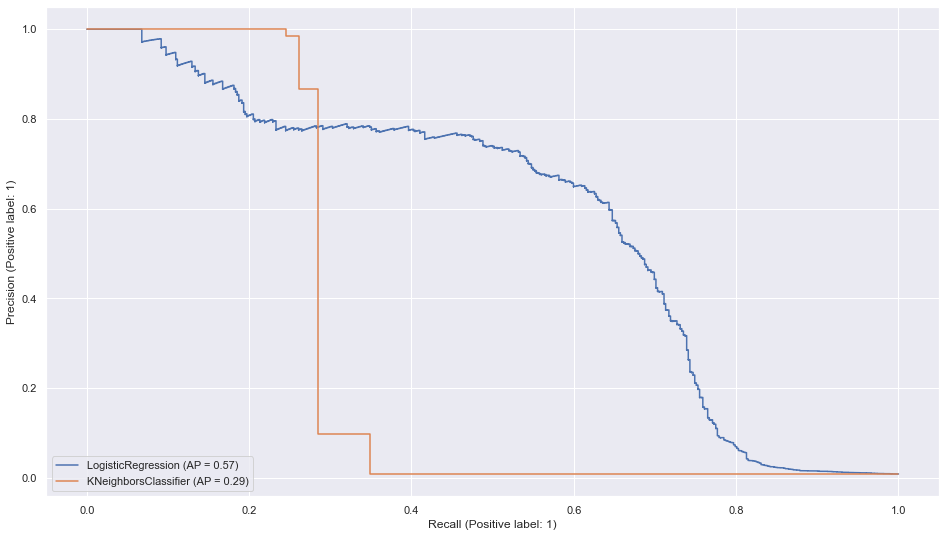

In [203]:
from sklearn.metrics import plot_precision_recall_curve

plt.figure(figsize=(16, 9))
pr_disp = plot_precision_recall_curve(logreg, X_test, y_test, ax=plt.axes())
plot_precision_recall_curve(knn, X_test, y_test, ax=pr_disp.ax_);

### ROC (Receiver Operating Characteristic)-кривая

**True Positive Rate** (Recall) - доля верных ответов среди всех *истинных* объектов позитивного класса
$$
    TPR = \frac{TP}{TP + FN}
$$
**False Positive Rate** - доля верных ответов среди всех *истинных* объектов негативного класса
$$
    FPR = \frac{FP}{FP + TN}
$$

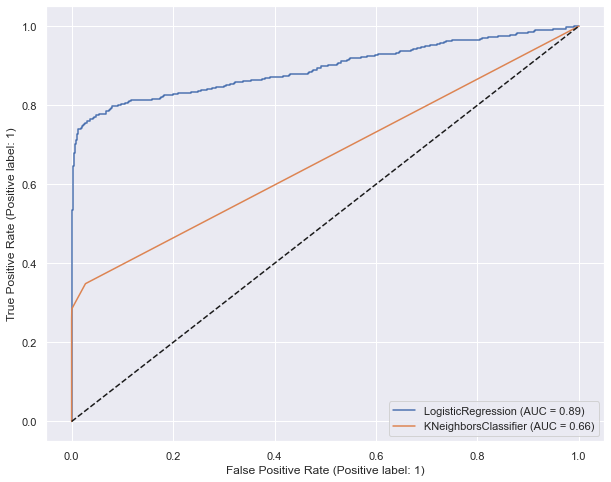

In [204]:
from sklearn.metrics import plot_roc_curve

plt.figure(figsize=(10, 8))
roc_disp = plot_roc_curve(logreg, X_test, y_test, ax=plt.axes())
plot_roc_curve(knn, X_test, y_test, ax=roc_disp.ax_)
roc_disp.ax_.plot([0, 1], [0, 1], 'k--');

### Площадь под ROC-кривой
ROC-AUC - ROC area under the curve

In [72]:
from sklearn.metrics import roc_auc_score

knn_y_pred_proba = knn.predict_proba(X_test)[:, 1]
logreg_y_pred_proba = logreg.predict_proba(X_test)[:, 1]

knn_roc_auc = roc_auc_score(y_test, knn_y_pred_proba)
logreg_roc_auc = roc_auc_score(y_test, logreg_y_pred_proba)
print(f"kNN ROC-AUC = {knn_roc_auc:.5}")
print(f"LogReg ROC-AUC = {logreg_roc_auc:.5}")

kNN ROC-AUC = 0.66452
LogReg ROC-AUC = 0.893
